<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [ ]:
!pip install pyvis==0.3.1

Error al cargar el fichero tablero, usando tablero aleatorio...
Error al cargar el fichero secuencia, usando secuencia aleatoria...
Que empiece el juego:😉


,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,.,.,a,a,.,.
B,.,a,.,.,a,.,1,a,.,.
C,.,.,.,.,.,.,a,.,a,.
D,.,.,.,1,a,.,.,.,.,.
E,.,.,.,.,.,.,.,a,.,.
F,a,.,1,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,1,a,a
H,.,b,.,.,a,.,1,.,a,.
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 0 Puntos:-14
Almacen: [.] Actual: [a]


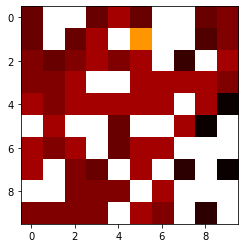

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,.,.,a,a,.,.
B,.,a,.,.,a,a,2,a,.,.
C,.,.,.,.,.,.,a,.,a,.
D,.,.,.,1,a,.,.,.,.,.
E,.,.,.,.,.,.,.,a,.,.
F,a,.,1,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,1,a,a
H,.,b,.,.,a,.,1,.,a,.
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 1 Puntos:7
Almacen: [.] Actual: [a]


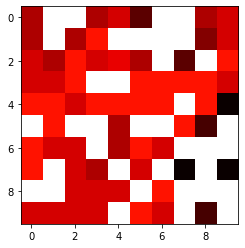

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,.,.,a,a,.,.
B,.,a,.,b,.,.,2,a,.,.
C,.,.,.,1,.,.,a,.,a,.
D,.,.,.,.,a,.,.,.,.,.
E,.,.,1,.,.,.,.,a,.,.
F,a,.,.,a,.,a,c,1,.,a
G,.,.,.,a,.,.,1,.,a,a
H,.,b,.,.,a,.,.,.,a,.
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 2 Puntos:10
Almacen: [.] Actual: [1]


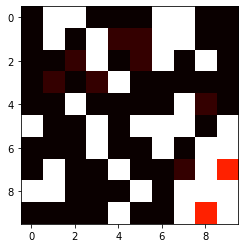

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,.,.,a,a,.,.
B,.,a,.,b,.,.,2,a,.,.
C,.,.,.,.,1,.,a,.,a,.
D,.,.,1,.,a,.,.,.,.,.
E,.,.,.,.,.,.,.,a,.,.
F,a,.,.,a,.,a,c,.,1,a
G,.,.,.,a,.,.,.,1,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 3 Puntos:5
Almacen: [.] Actual: [a]


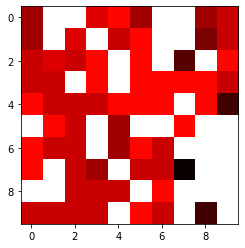

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,.,.
B,.,a,.,b,1,.,2,a,.,.
C,.,.,1,.,.,.,a,.,a,.
D,.,.,.,.,a,.,.,.,.,.
E,.,.,.,.,.,.,.,a,1,.
F,a,.,.,a,.,a,c,1,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 4 Puntos:6
Almacen: [.] Actual: [a]


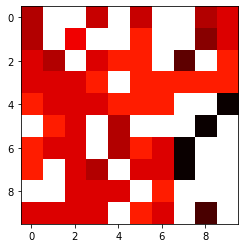

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,.,.
B,.,a,1,b,.,a,2,a,.,.
C,.,.,.,.,1,.,a,.,a,.
D,.,.,.,.,a,.,.,.,1,.
E,.,.,.,.,.,.,.,a,.,.
F,a,.,.,a,.,a,c,.,1,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 5 Puntos:7
Almacen: [.] Actual: [a]


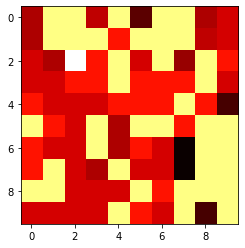

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,.,.
B,.,a,2,b,1,a,2,a,.,.
C,.,.,a,.,.,.,a,.,a,.
D,.,.,.,.,a,.,.,.,.,1
E,.,.,.,.,.,.,.,a,1,.
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 6 Puntos:28
Almacen: [.] Actual: [a]


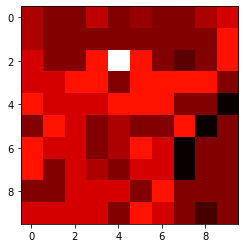

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,.,.
B,.,a,2,b,2,a,2,a,.,.
C,.,.,a,.,a,.,a,.,a,1
D,.,.,.,.,a,.,.,.,1,.
E,.,.,.,.,.,.,.,a,.,.
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 7 Puntos:49
Almacen: [.] Actual: [a]


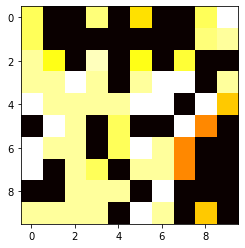

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,.,a
B,.,a,2,b,2,a,2,a,.,1
C,.,.,a,.,a,.,a,.,a,.
D,.,.,.,.,a,.,.,.,.,1
E,.,.,.,.,.,.,.,a,.,.
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 8 Puntos:50
Almacen: [.] Actual: [a]


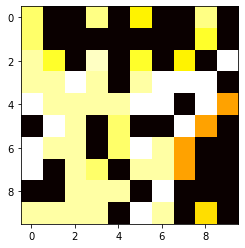

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,.,a
B,.,a,2,b,2,a,2,a,1,.
C,.,.,a,.,a,.,a,.,a,a
D,.,.,.,.,a,.,.,.,.,.
E,.,.,.,.,.,.,.,a,.,1
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 9 Puntos:51
Almacen: [.] Actual: [a]


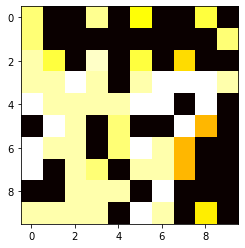

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,1,a
B,.,a,2,b,2,a,2,a,.,.
C,.,.,a,.,a,.,a,.,a,a
D,.,.,a,.,a,.,.,.,.,1
E,.,.,.,.,.,.,.,a,.,.
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 10 Puntos:52
Almacen: [.] Actual: [a]


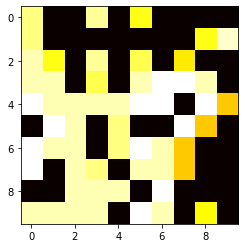

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,.,a
B,.,a,2,b,2,a,2,a,1,.
C,.,.,a,.,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,.,.
E,.,.,.,.,.,.,.,a,.,1
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 11 Puntos:53
Almacen: [.] Actual: [a]


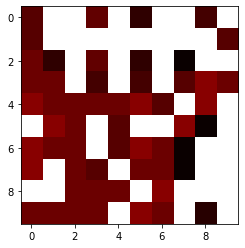

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,1,a
B,.,a,2,b,2,a,2,a,x,.
C,.,.,a,.,a,.,a,.,.,.
D,.,.,a,.,a,.,a,.,b,1
E,.,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 12 Puntos:-44
Almacen: [.] Actual: [a]


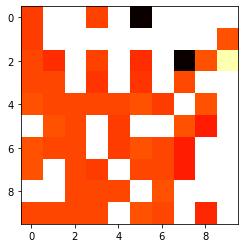

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,2,a
B,.,a,2,b,2,a,2,a,x,.
C,.,.,a,.,a,.,a,.,.,a
D,.,.,a,.,a,.,a,.,b,2
E,.,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 13 Puntos:-3
Almacen: [.] Actual: [a]


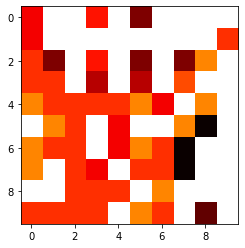

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,2,a
B,.,a,2,b,2,a,2,a,x,.
C,.,.,a,.,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,.,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 14 Puntos:-2
Almacen: [.] Actual: [a]


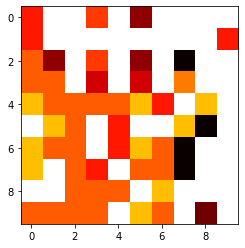

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,.,a,a,2,a
B,.,a,2,b,2,a,2,a,x,.
C,.,.,a,.,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,a,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 15 Puntos:-1
Almacen: [.] Actual: [b]


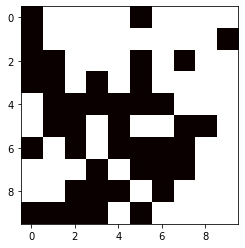

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,b,a,.,a,a,2,a
B,.,a,2,b,2,a,2,a,x,.
C,.,.,a,.,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,a,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 16 Puntos:4
Almacen: [.] Actual: [1]


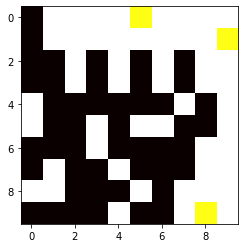

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,b,a,2,a,a,2,a
B,.,a,2,b,2,a,2,a,x,.
C,.,.,a,.,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,a,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 17 Puntos:-1
Almacen: [.] Actual: [a]


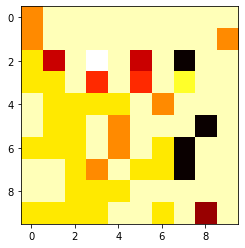

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,2,a,a,2,a
B,.,a,2,.,2,a,2,a,x,.
C,.,.,.,c,.,.,a,.,a,a
D,.,.,.,.,.,.,a,.,b,2
E,a,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 18 Puntos:10
Almacen: [.] Actual: [a]


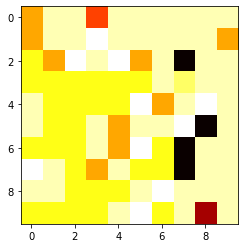

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,.
C,.,.,.,c,.,.,a,.,a,a
D,.,.,.,.,.,.,a,.,b,2
E,a,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 19 Puntos:11
Almacen: [.] Actual: [a]


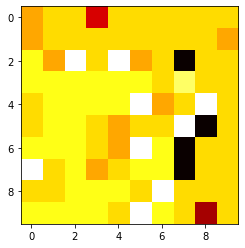

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,.
C,.,.,a,c,.,.,a,.,a,a
D,.,.,.,.,.,.,a,.,b,2
E,a,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 20 Puntos:12
Almacen: [.] Actual: [a]


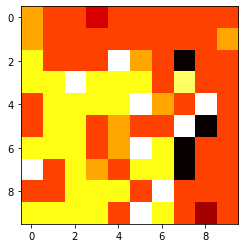

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,.
C,.,.,a,c,a,.,a,.,a,a
D,.,.,.,.,.,.,a,.,b,2
E,a,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 21 Puntos:13
Almacen: [.] Actual: [a]


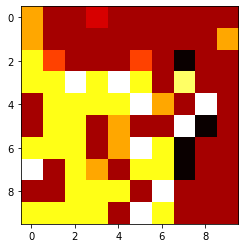

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,.
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,.,.,a,.,b,2
E,a,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 22 Puntos:14
Almacen: [.] Actual: [a]


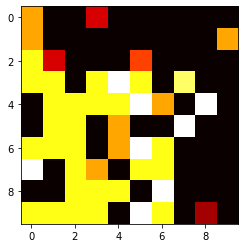

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,.
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,a,.,.,.,.,.,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 23 Puntos:15
Almacen: [.] Actual: [a]


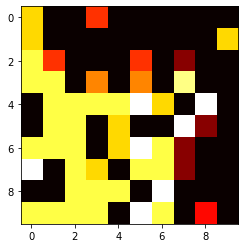

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,.
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,a,.,.,.,.,a,.,a,.,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 24 Puntos:16
Almacen: [.] Actual: [a]


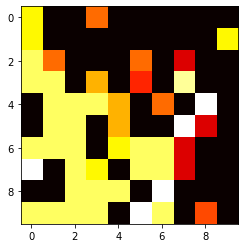

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,.
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,a,.,.,.,.,a,.,a,a,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,.,b,.,.,a,.,.,.,a,2
I,a,a,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 25 Puntos:17
Almacen: [.] Actual: [a]


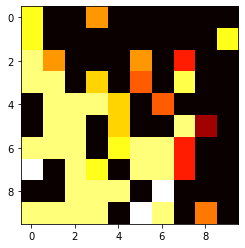

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,.,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,.
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,a,.,.,.,.,a,.,a,a,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,b,b,.,.,a,.,.,.,a,2
I,.,.,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 26 Puntos:20
Almacen: [.] Actual: [1]


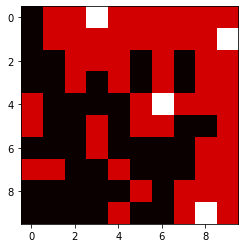

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,.
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,a,.,.,.,.,a,.,a,a,x
F,a,.,.,a,.,a,c,.,.,a
G,.,.,.,a,.,.,.,.,a,a
H,b,b,.,.,a,.,.,.,a,2
I,.,.,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 27 Puntos:15
Almacen: [.] Actual: [a]


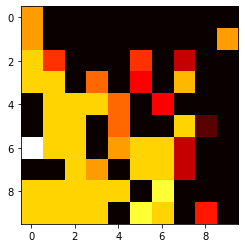

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,.
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,.,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,.,.,.,a,2
I,.,.,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 28 Puntos:28
Almacen: [.] Actual: [1]


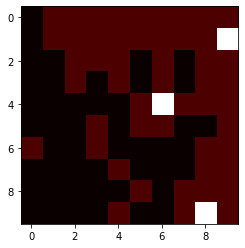

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,.,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,.,.,.,a,2
I,.,.,.,.,.,a,.,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 29 Puntos:23
Almacen: [.] Actual: [a]


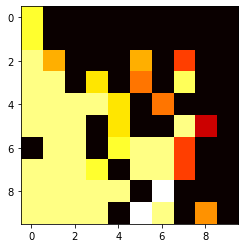

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,.,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,.,.,.,a,2
I,.,.,.,.,.,a,a,c,a,a
J,.,.,.,.,c,.,.,b,.,a



Turno: 30 Puntos:24
Almacen: [.] Actual: [a]


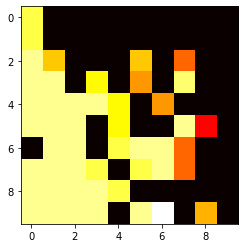

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,.,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,.,.,.,a,2
I,.,.,.,.,.,.,.,c,a,a
J,.,.,.,.,c,.,b,b,.,a



Turno: 31 Puntos:27
Almacen: [.] Actual: [a]


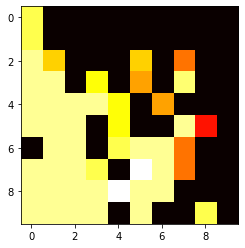

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,.,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,.,c,a,a
J,.,.,.,.,c,.,b,b,.,a



Turno: 32 Puntos:28
Almacen: [.] Actual: [b]


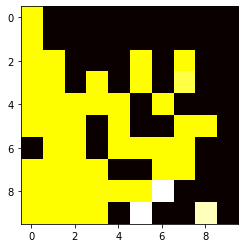

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,.,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 33 Puntos:43
Almacen: [.] Actual: [a]


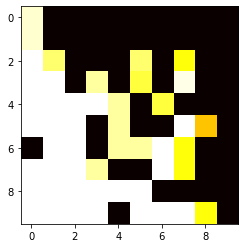

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,a,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,.,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 34 Puntos:44
Almacen: [.] Actual: [a]


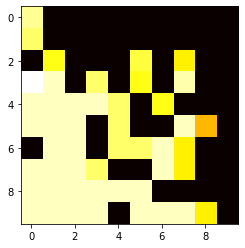

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,a,.,a,c,a,.,a,.,a,a
D,a,.,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,.,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 35 Puntos:45
Almacen: [.] Actual: [a]


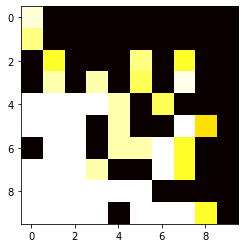

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,b,.,.,.,.,a,.,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 36 Puntos:48
Almacen: [.] Actual: [1]


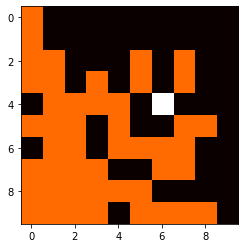

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,.,a,.,a,.,a,.,b,2
E,b,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 37 Puntos:43
Almacen: [.] Actual: [b]


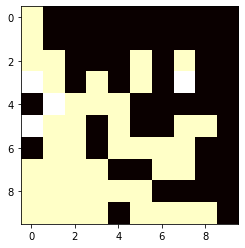

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,b,.,a,.,a,.,a,.,b,2
E,b,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 38 Puntos:48
Almacen: [.] Actual: [a]


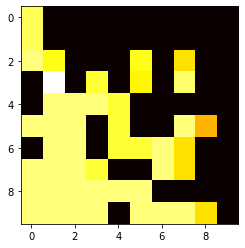

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,.,c,a,.,a,.,a,a
D,.,c,.,.,a,.,a,.,b,2
E,.,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 39 Puntos:61
Almacen: [.] Actual: [a]


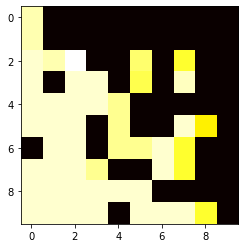

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,c,.,.,a,.,a,.,b,2
E,.,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 40 Puntos:62
Almacen: [.] Actual: [a]


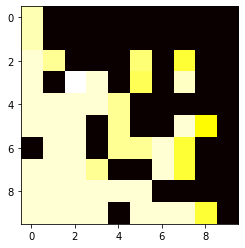

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,c,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 41 Puntos:63
Almacen: [.] Actual: [1]


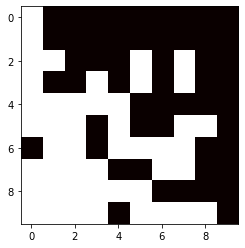

,0,1,2,3,4,5,6,7,8,9
A,1,a,a,2,a,2,a,a,2,a
B,.,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,c,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 42 Puntos:38
Almacen: [.] Actual: [a]


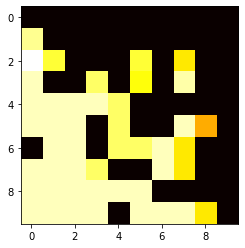

,0,1,2,3,4,5,6,7,8,9
A,.,a,a,2,a,2,a,a,2,a
B,1,a,2,a,2,a,2,a,x,2
C,a,.,a,c,a,.,a,.,a,a
D,.,c,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 43 Puntos:39
Almacen: [.] Actual: [b]


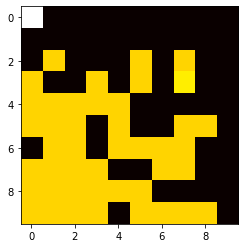

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,.,a,c,a,.,a,.,a,a
D,.,c,a,.,a,.,a,.,b,2
E,.,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 44 Puntos:64
Almacen: [.] Actual: [b]


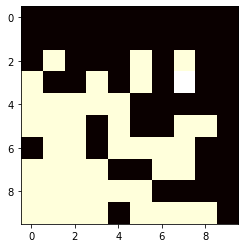

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,.,a,c,a,.,a,.,a,a
D,.,c,a,.,a,.,a,b,b,2
E,.,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 45 Puntos:69
Almacen: [.] Actual: [a]


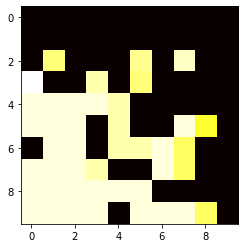

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,.,a,c,a,.,a,.,a,a
D,a,c,a,.,a,.,a,b,b,2
E,.,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 46 Puntos:70
Almacen: [.] Actual: [a]


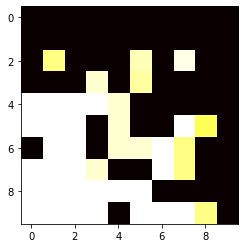

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,.,.,a,c,a,.,a,.,a,a
D,.,c,a,.,a,.,a,b,b,2
E,b,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 47 Puntos:73
Almacen: [.] Actual: [a]


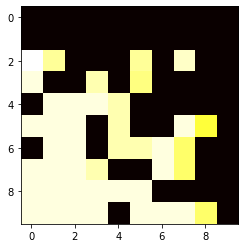

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,.,a,c,a,.,a,.,a,a
D,.,c,a,.,a,.,a,b,b,2
E,b,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 48 Puntos:74
Almacen: [.] Actual: [1]


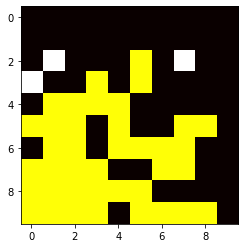

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,.,a,a
D,.,c,a,.,a,.,a,b,b,2
E,b,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 49 Puntos:69
Almacen: [.] Actual: [a]


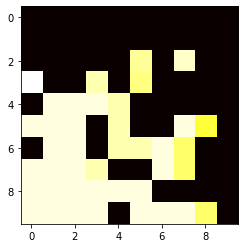

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,.,a,a
D,a,c,a,.,a,.,a,b,b,2
E,b,.,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 50 Puntos:70
Almacen: [.] Actual: [a]


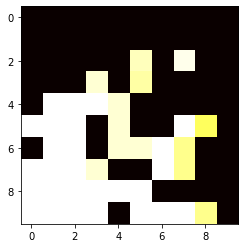

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,.,a,a
D,a,c,a,.,a,.,a,b,b,2
E,b,a,.,.,.,a,2,a,a,x
F,.,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 51 Puntos:71
Almacen: [.] Actual: [a]


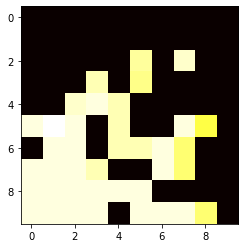

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,.,a,a
D,a,c,a,.,a,.,a,b,b,2
E,b,a,.,.,.,a,2,a,a,x
F,.,a,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 52 Puntos:72
Almacen: [.] Actual: [a]


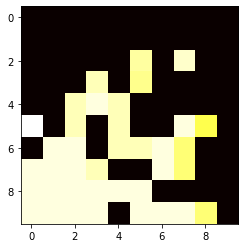

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,.,a,a
D,a,c,a,.,a,.,a,b,b,2
E,b,.,.,.,.,a,2,a,a,x
F,b,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 53 Puntos:75
Almacen: [.] Actual: [a]


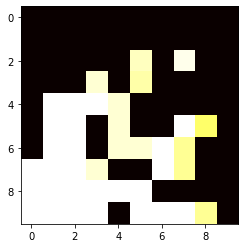

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,.,a,a
D,a,c,a,.,a,.,a,b,b,2
E,b,a,.,.,.,a,2,a,a,x
F,b,.,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 54 Puntos:76
Almacen: [.] Actual: [a]


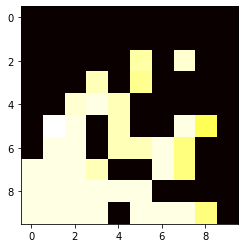

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,.,a,a
D,a,c,a,.,a,.,a,b,b,2
E,b,a,.,.,.,a,2,a,a,x
F,b,a,.,a,.,a,c,.,.,a
G,c,.,.,a,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 55 Puntos:77
Almacen: [.] Actual: [a]


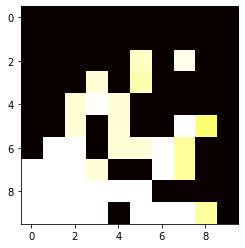

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,.,a,a
D,a,c,a,.,a,.,a,b,b,2
E,b,a,.,b,.,a,2,a,a,x
F,b,a,.,.,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 56 Puntos:80
Almacen: [.] Actual: [b]


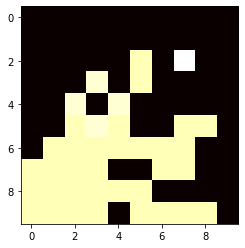

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,.,a,.,a,.,.,2
E,b,a,.,b,.,a,2,a,a,x
F,b,a,.,.,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 57 Puntos:95
Almacen: [.] Actual: [1]


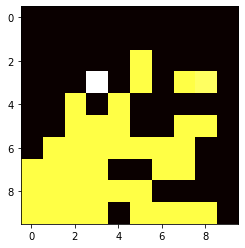

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,2,a,.,a,.,.,2
E,b,a,.,b,.,a,2,a,a,x
F,b,a,.,.,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 58 Puntos:90
Almacen: [.] Actual: [a]


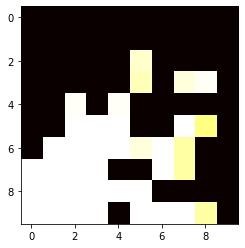

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,2,a,.,a,.,.,2
E,b,.,.,b,.,a,2,a,a,x
F,b,.,b,.,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 59 Puntos:93
Almacen: [.] Actual: [a]


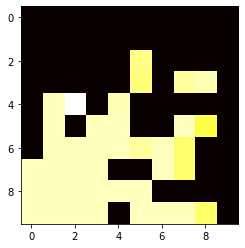

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,.,c,a,.,a,c,a,a
D,a,c,.,2,a,.,a,.,.,2
E,b,.,c,.,.,a,2,a,a,x
F,b,.,.,.,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 60 Puntos:106
Almacen: [.] Actual: [a]


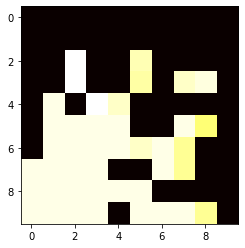

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,.,2,a,.,a,.,.,2
E,b,.,c,.,.,a,2,a,a,x
F,b,.,.,.,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 61 Puntos:107
Almacen: [.] Actual: [a]


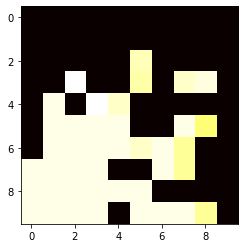

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,2,a,.,a,.,.,2
E,b,.,c,.,.,a,2,a,a,x
F,b,.,.,.,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 62 Puntos:108
Almacen: [.] Actual: [a]


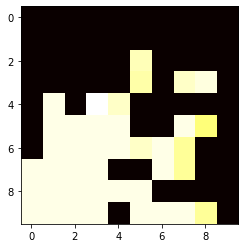

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,2,a,.,a,.,.,2
E,b,.,c,a,.,a,2,a,a,x
F,b,.,.,.,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 63 Puntos:109
Almacen: [.] Actual: [a]


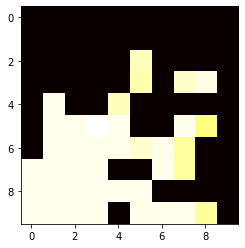

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,x,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,2,a,.,a,.,.,2
E,b,.,c,a,.,a,2,a,a,x
F,b,.,.,a,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 64 Puntos:110
Almacen: [.] Actual: [w]


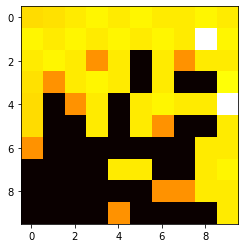

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,.,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,2,a,.,a,.,.,2
E,b,.,c,a,.,a,2,a,a,x
F,b,.,.,a,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 65 Puntos:160
Almacen: [.] Actual: [a]


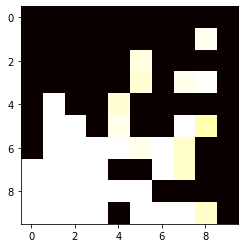

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,.,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,2,a,.,a,.,.,2
E,b,a,c,a,.,a,2,a,a,x
F,b,.,.,a,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 66 Puntos:161
Almacen: [.] Actual: [a]


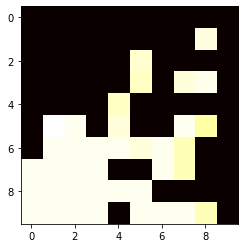

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,.,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,2,a,.,a,.,.,2
E,b,a,c,a,.,a,2,a,a,x
F,b,a,.,a,.,a,c,.,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 67 Puntos:162
Almacen: [.] Actual: [a]


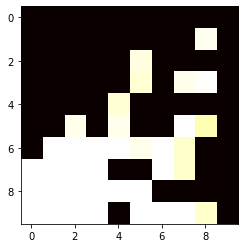

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,2,a
B,2,a,2,a,2,a,2,a,.,2
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,2,a,.,a,.,.,2
E,b,a,c,a,.,a,2,.,.,x
F,b,a,.,a,.,a,c,b,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 68 Puntos:165
Almacen: [.] Actual: [1]


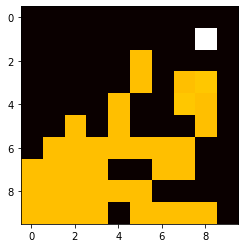

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,.,a,c,a,a
D,a,c,a,2,a,.,a,.,.,2
E,b,a,c,a,.,a,2,.,.,x
F,b,a,.,a,.,a,c,b,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 69 Puntos:225
Almacen: [.] Actual: [a]


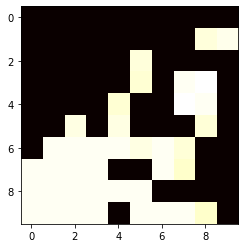

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,.,a,c,.,.
D,a,c,a,2,a,.,a,.,b,2
E,b,a,c,a,.,a,2,.,.,x
F,b,a,.,a,.,a,c,b,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 70 Puntos:228
Almacen: [.] Actual: [a]


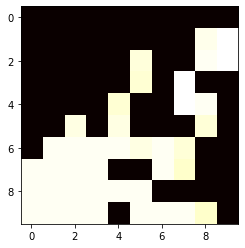

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,.,a
C,a,2,a,c,a,.,a,c,.,.
D,a,c,a,2,a,.,a,.,b,2
E,b,a,c,a,.,a,2,.,.,x
F,b,a,.,a,.,a,c,b,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 71 Puntos:229
Almacen: [.] Actual: [a]


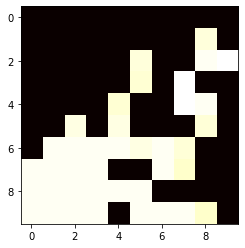

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,.,a,c,.,b
D,a,c,a,2,a,.,a,.,b,2
E,b,a,c,a,.,a,2,.,.,x
F,b,a,.,a,.,a,c,b,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 72 Puntos:232
Almacen: [.] Actual: [a]


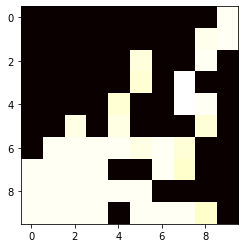

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,.,.,c,.,b
D,a,c,a,2,a,.,.,b,b,2
E,b,a,c,a,.,a,2,.,.,x
F,b,a,.,a,.,a,c,b,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 73 Puntos:235
Almacen: [.] Actual: [1]


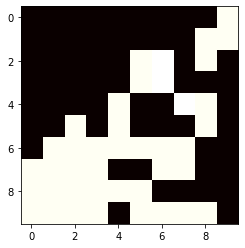

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,.,1,c,.,b
D,a,c,a,2,a,.,.,b,b,2
E,b,a,c,a,.,a,2,.,.,x
F,b,a,.,a,.,a,c,b,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 74 Puntos:210
Almacen: [.] Actual: [a]


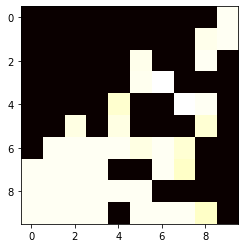

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,1,.,c,.,b
D,a,c,a,2,a,.,a,b,b,2
E,b,a,c,a,.,a,2,.,.,x
F,b,a,.,a,.,a,c,b,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 75 Puntos:211
Almacen: [.] Actual: [b]


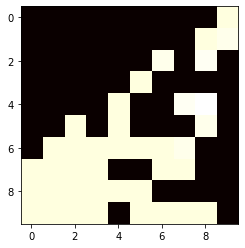

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,.,1,c,.,b
D,a,c,a,2,a,.,a,.,.,2
E,b,a,c,a,.,a,2,.,c,x
F,b,a,.,a,.,a,c,b,.,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 76 Puntos:226
Almacen: [.] Actual: [1]


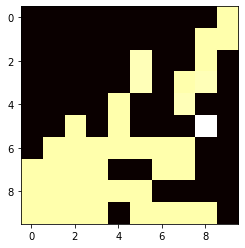

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,1,.,c,.,b
D,a,c,a,2,a,.,a,.,.,2
E,b,a,c,a,.,a,2,.,c,x
F,b,a,.,a,.,a,c,b,2,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 77 Puntos:221
Almacen: [.] Actual: [a]


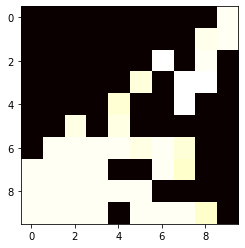

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,.,a,c,.,b
D,a,c,a,2,a,1,a,.,.,2
E,b,a,c,a,.,a,2,.,c,x
F,b,a,.,a,.,a,c,b,2,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 78 Puntos:222
Almacen: [.] Actual: [b]


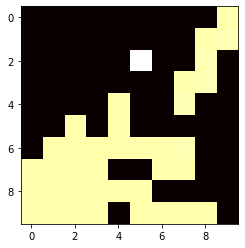

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,b,a,c,.,b
D,a,c,a,2,a,2,a,.,.,2
E,b,a,c,a,.,a,2,.,c,x
F,b,a,.,a,.,a,c,b,2,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 79 Puntos:247
Almacen: [.] Actual: [a]


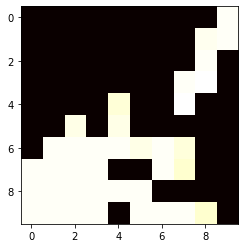

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,b,a,c,.,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,.,c,x
F,b,a,.,a,.,a,c,b,2,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 80 Puntos:248
Almacen: [.] Actual: [a]


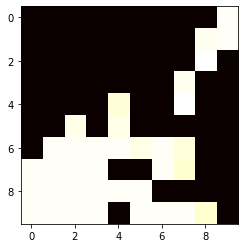

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,.,c,x
F,b,a,.,a,.,a,c,b,2,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 81 Puntos:249
Almacen: [.] Actual: [a]


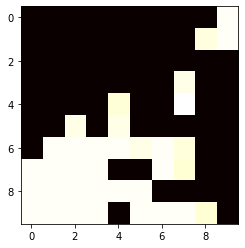

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,.
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,x
F,b,a,.,a,.,a,c,b,2,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 82 Puntos:250
Almacen: [.] Actual: [a]


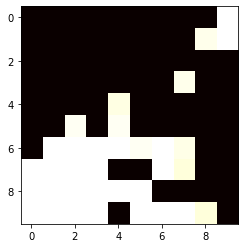

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,.,.
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,x
F,b,a,.,a,.,a,c,b,2,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 83 Puntos:251
Almacen: [.] Actual: [a]


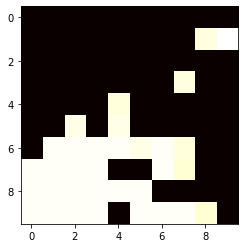

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,.,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,x
F,b,a,.,a,.,a,c,b,2,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 84 Puntos:252
Almacen: [.] Actual: [1]


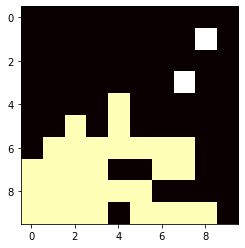

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,x
F,b,a,.,a,.,a,c,b,2,a
G,c,.,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 85 Puntos:247
Almacen: [.] Actual: [a]


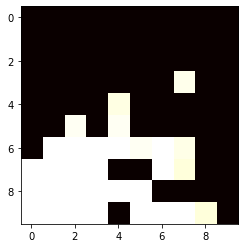

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,.,c,a,.,a,2,a,c,x
F,b,.,.,a,.,a,c,b,2,a
G,c,b,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 86 Puntos:250
Almacen: [.] Actual: [a]


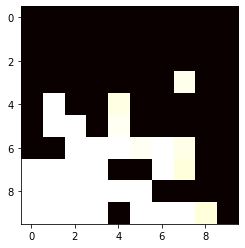

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,x
F,b,.,.,a,.,a,c,b,2,a
G,c,b,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 87 Puntos:251
Almacen: [.] Actual: [w]


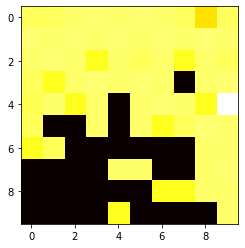

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,.
F,b,.,.,a,.,a,c,b,2,a
G,c,b,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 88 Puntos:301
Almacen: [.] Actual: [a]


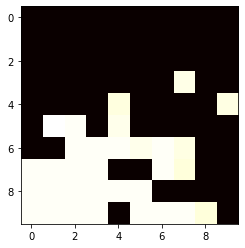

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,.
F,b,a,.,a,.,a,c,b,2,a
G,c,b,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 89 Puntos:302
Almacen: [.] Actual: [1]


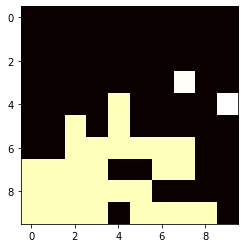

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,.,a,.,a,c,b,2,a
G,c,b,.,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 90 Puntos:297
Almacen: [.] Actual: [b]


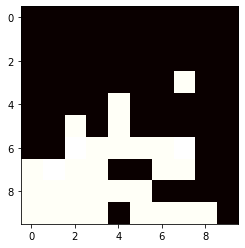

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,.,a,.,a,c,b,2,a
G,c,b,b,.,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 91 Puntos:302
Almacen: [.] Actual: [a]


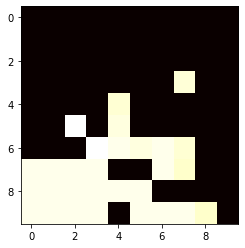

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,.,.,a,2,a,c,2
F,b,a,.,.,.,a,c,b,2,a
G,c,.,.,c,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 92 Puntos:315
Almacen: [.] Actual: [a]


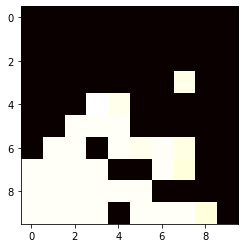

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,.,.,.,a,c,b,2,a
G,c,.,.,c,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 93 Puntos:316
Almacen: [.] Actual: [a]


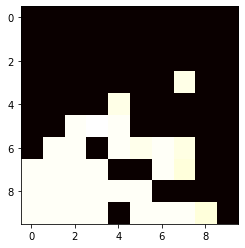

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,.,a,.,a,c,b,2,a
G,c,.,.,c,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 94 Puntos:317
Almacen: [.] Actual: [a]


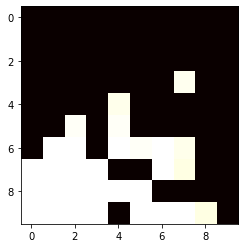

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,.,c,a,.,a,2,a,c,2
F,b,.,.,a,.,a,c,b,2,a
G,c,b,.,c,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 95 Puntos:320
Almacen: [.] Actual: [a]


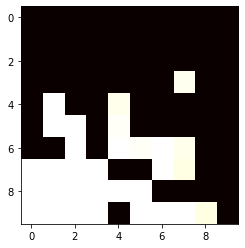

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,.,.,a,.,a,c,b,2,a
G,c,b,.,c,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 96 Puntos:321
Almacen: [.] Actual: [a]


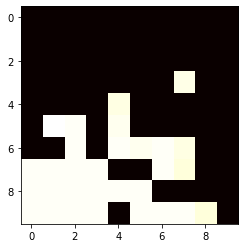

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,.,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,.,a,.,a,c,b,2,a
G,c,b,.,c,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 97 Puntos:322
Almacen: [.] Actual: [1]


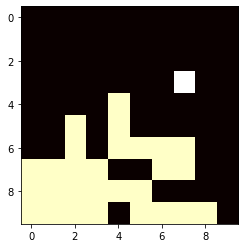

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,.,a,.,a,c,b,2,a
G,c,b,.,c,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 98 Puntos:317
Almacen: [.] Actual: [a]


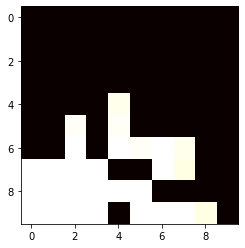

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,.,a,.,a,c,b,2,a
G,c,b,a,c,.,.,.,.,a,a
H,.,.,.,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 99 Puntos:318
Almacen: [.] Actual: [a]


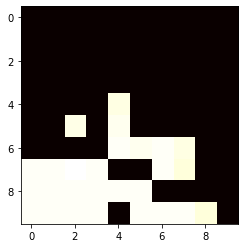

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,.,a,.,a,c,b,2,a
G,c,b,a,c,.,.,.,.,a,a
H,.,.,a,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 100 Puntos:319
Almacen: [.] Actual: [b]


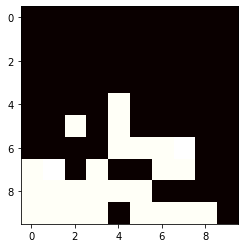

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,.,a,.,a,c,b,2,a
G,c,b,a,c,.,.,.,b,a,a
H,.,.,a,.,a,a,.,.,a,2
I,.,.,.,.,.,.,c,c,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 101 Puntos:324
Almacen: [.] Actual: [b]


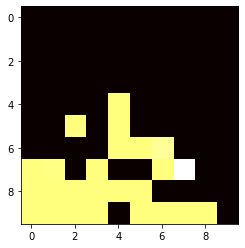

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,.,a,.,a,c,.,2,a
G,c,b,a,c,.,.,.,.,a,a
H,.,.,a,.,a,a,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 102 Puntos:389
Almacen: [.] Actual: [1]


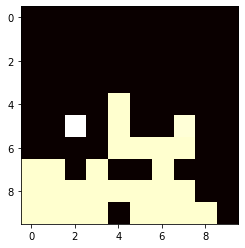

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,2,a,.,a,c,.,2,a
G,c,b,a,c,.,.,.,.,a,a
H,.,.,a,.,a,a,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 103 Puntos:384
Almacen: [.] Actual: [a]


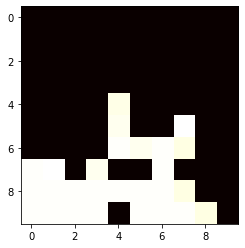

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,2,a,.,a,c,a,2,a
G,c,b,a,c,.,.,.,.,a,a
H,.,.,a,.,a,a,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 104 Puntos:385
Almacen: [.] Actual: [1]


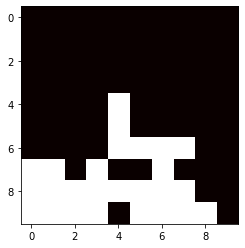

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,a,1,a,2,a,c,2
F,b,a,2,a,.,a,c,a,2,a
G,c,b,a,c,.,.,.,.,a,a
H,.,.,a,.,a,a,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 105 Puntos:360
Almacen: [.] Actual: [a]


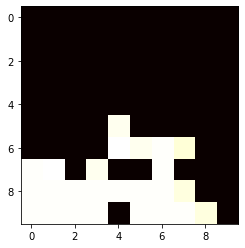

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,a,.,a,2,a,c,2
F,b,a,2,a,1,a,c,a,2,a
G,c,b,a,c,b,.,.,.,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 106 Puntos:363
Almacen: [.] Actual: [a]


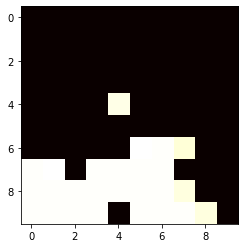

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,a,1,.,2,a,c,2
F,b,a,2,a,.,.,c,a,2,a
G,c,b,a,c,b,b,.,.,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 107 Puntos:366
Almacen: [.] Actual: [a]


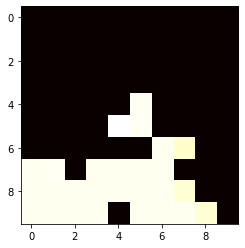

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,.,.,1,2,a,c,2
F,b,a,2,.,c,.,c,a,2,a
G,c,b,a,c,.,.,.,.,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 108 Puntos:379
Almacen: [.] Actual: [1]


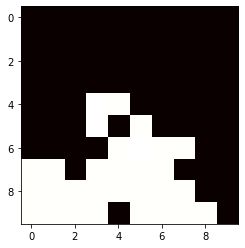

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,1,.,.,2,a,c,2
F,b,a,2,.,c,1,c,a,2,a
G,c,b,a,c,.,.,.,.,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 109 Puntos:354
Almacen: [.] Actual: [1]


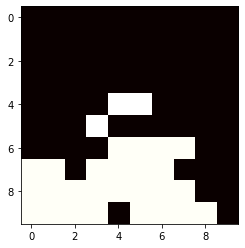

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,.,1,1,2,a,c,2
F,b,a,2,1,c,.,c,a,2,a
G,c,b,a,c,.,.,.,.,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 110 Puntos:329
Almacen: [.] Actual: [1]


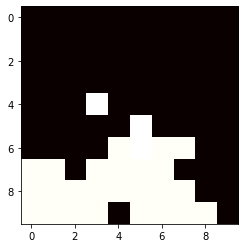

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,2,a,2,a,2,a,2
E,b,a,c,1,.,1,2,a,c,2
F,b,a,2,1,c,1,c,a,2,a
G,c,b,a,c,.,.,.,.,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 111 Puntos:304
Almacen: [.] Actual: [a]


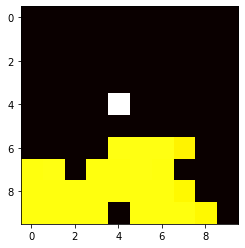

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,.,b,a,c,a,b
D,a,c,a,3,.,2,a,2,a,2
E,b,a,c,.,b,1,2,a,c,2
F,b,a,.,.,c,.,c,a,2,a
G,c,b,a,c,.,1,.,.,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 112 Puntos:417
Almacen: [.] Actual: [b]


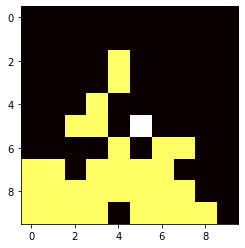

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,.,b,a,c,a,b
D,a,c,a,3,.,.,a,2,a,2
E,b,a,c,.,b,.,3,a,c,2
F,b,a,.,.,c,b,c,a,2,a
G,c,b,a,c,.,.,1,.,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 113 Puntos:507
Almacen: [.] Actual: [a]


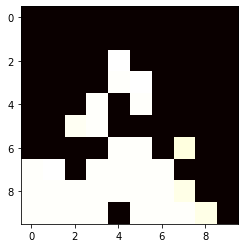

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,.,.,a,2,a,2
E,b,a,c,.,b,.,3,a,c,2
F,b,a,.,.,c,b,c,a,2,a
G,c,b,a,c,.,.,.,1,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 114 Puntos:508
Almacen: [.] Actual: [a]


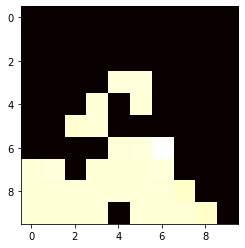

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,.,.,a,2,a,2
E,b,a,c,.,b,.,3,a,c,2
F,b,a,.,.,c,b,c,a,2,a
G,c,b,a,c,.,.,a,2,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 115 Puntos:529
Almacen: [.] Actual: [a]


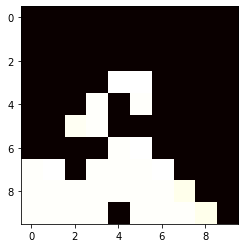

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,.,a,2,a,2
E,b,a,c,.,b,.,3,a,c,2
F,b,a,.,.,c,b,c,a,2,a
G,c,b,a,c,.,.,a,2,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 116 Puntos:530
Almacen: [.] Actual: [b]


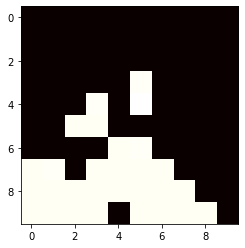

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,.,a,2,a,2
E,b,a,c,.,.,c,3,a,c,2
F,b,a,.,.,c,.,c,a,2,a
G,c,b,a,c,.,.,a,2,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 117 Puntos:545
Almacen: [.] Actual: [1]


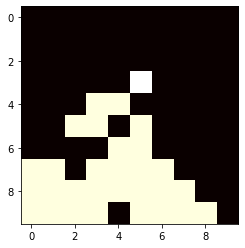

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,.,.,c,3,a,c,2
F,b,a,.,.,c,.,c,a,2,a
G,c,b,a,c,.,.,a,2,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 118 Puntos:540
Almacen: [.] Actual: [a]


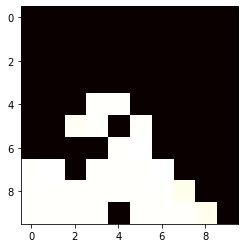

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,.,.,c,3,a,c,2
F,b,a,.,.,c,.,c,a,2,a
G,c,b,a,c,.,a,a,2,a,a
H,.,.,a,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 119 Puntos:541
Almacen: [.] Actual: [a]


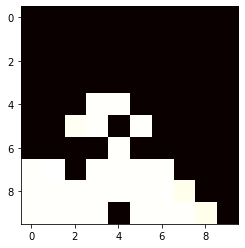

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,.,.,c,3,a,c,2
F,b,a,.,.,c,.,c,a,2,a
G,c,b,.,c,.,a,a,2,a,a
H,.,b,.,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 120 Puntos:544
Almacen: [.] Actual: [b]


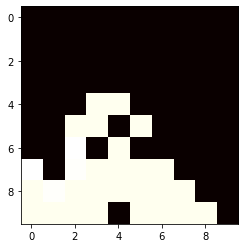

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,.,.,c,3,a,c,2
F,b,a,.,.,c,.,c,a,2,a
G,c,.,c,c,.,a,a,2,a,a
H,.,.,.,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 121 Puntos:559
Almacen: [.] Actual: [a]


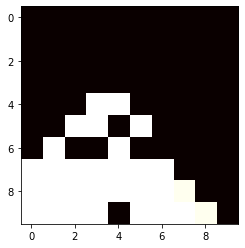

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,.,c,3,a,c,2
F,b,a,.,.,c,.,c,a,2,a
G,c,.,c,c,.,a,a,2,a,a
H,.,.,.,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 122 Puntos:560
Almacen: [.] Actual: [1]


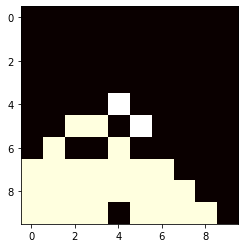

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,.,.,c,.,c,a,2,a
G,c,.,c,c,.,a,a,2,a,a
H,.,.,.,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 123 Puntos:555
Almacen: [.] Actual: [a]


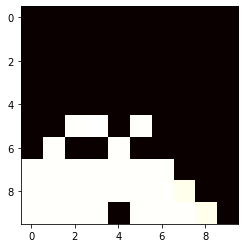

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,.,a,c,.,c,a,2,a
G,c,.,c,c,.,a,a,2,a,a
H,.,.,.,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 124 Puntos:556
Almacen: [.] Actual: [a]


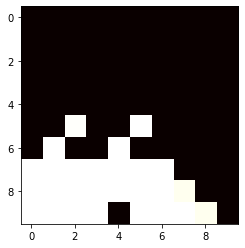

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,.,a,c,b,c,a,2,a
G,c,.,c,c,.,.,.,2,a,a
H,.,.,.,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 125 Puntos:559
Almacen: [.] Actual: [1]


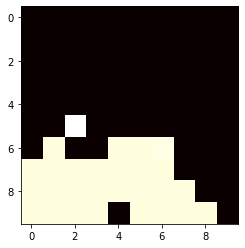

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,.,.,.,2,a,a
H,.,.,.,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 126 Puntos:554
Almacen: [.] Actual: [1]


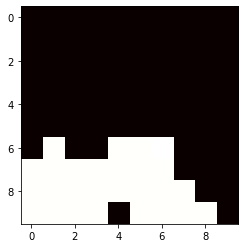

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,.,.,1,2,a,a
H,.,.,.,.,.,.,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 127 Puntos:529
Almacen: [.] Actual: [a]


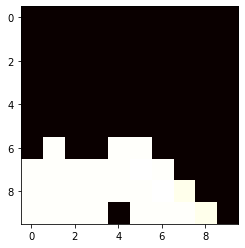

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,.,.,.,2,a,a
H,.,.,.,.,.,a,1,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 128 Puntos:530
Almacen: [.] Actual: [a]


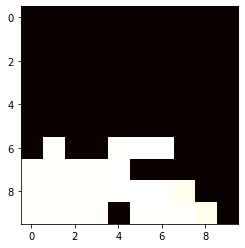

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,.,a,1,2,a,a
H,.,.,.,.,.,a,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 129 Puntos:531
Almacen: [.] Actual: [a]


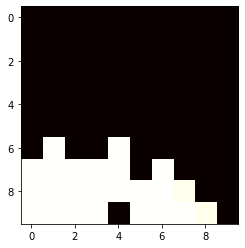

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,.,a,.,2,a,a
H,.,.,.,.,.,a,1,d,a,2
I,.,.,.,.,.,.,a,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 130 Puntos:532
Almacen: [.] Actual: [a]


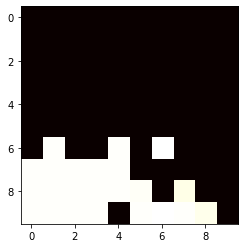

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,.,.,b,2,a,a
H,.,.,.,.,.,1,.,d,a,2
I,.,.,.,.,.,.,a,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 131 Puntos:535
Almacen: [.] Actual: [a]


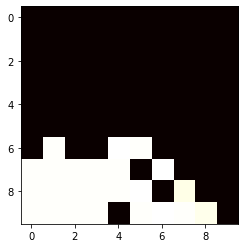

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,a,1,b,2,a,a
H,.,.,.,.,.,.,.,d,a,2
I,.,.,.,.,.,.,a,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 132 Puntos:536
Almacen: [.] Actual: [a]


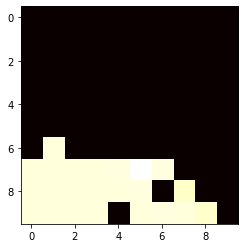

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,a,2,b,2,a,a
H,.,.,.,.,.,a,.,d,a,2
I,.,.,.,.,.,.,a,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 133 Puntos:557
Almacen: [.] Actual: [a]


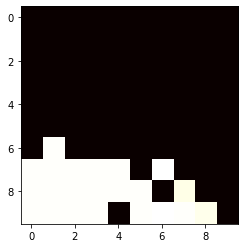

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,a,2,b,2,a,a
H,.,.,.,.,.,.,b,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 134 Puntos:560
Almacen: [.] Actual: [a]


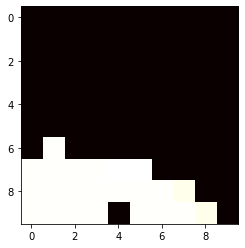

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,a,2,b,2,a,a
H,.,.,.,.,a,.,b,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 135 Puntos:561
Almacen: [.] Actual: [a]


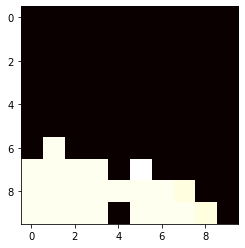

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,.,2,.,2,a,a
H,.,.,.,.,.,c,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 136 Puntos:574
Almacen: [.] Actual: [1]


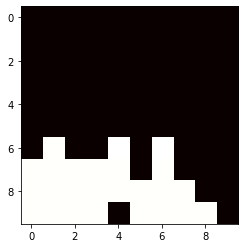

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,1,2,.,2,a,a
H,.,.,.,.,.,c,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 137 Puntos:549
Almacen: [.] Actual: [a]


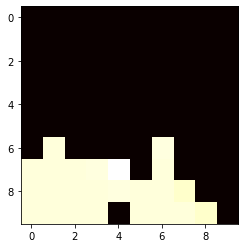

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,2,2,.,2,a,a
H,.,.,.,.,a,c,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 138 Puntos:570
Almacen: [.] Actual: [1]


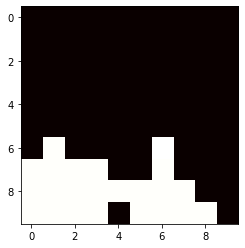

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,2,2,1,2,a,a
H,.,.,.,.,a,c,.,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 139 Puntos:545
Almacen: [.] Actual: [1]


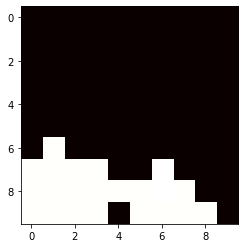

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,2,2,1,2,a,a
H,.,.,.,.,a,c,1,d,a,2
I,.,.,.,.,.,.,.,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 140 Puntos:520
Almacen: [.] Actual: [b]


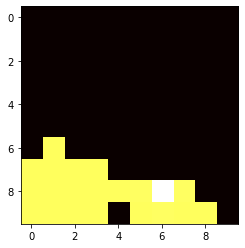

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,.,.,.,3,a,a
H,.,.,.,.,a,c,.,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 141 Puntos:640
Almacen: [.] Actual: [a]


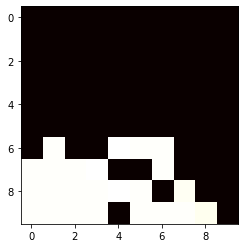

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,a,.,.,3,a,a
H,.,.,.,.,a,c,.,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 142 Puntos:641
Almacen: [.] Actual: [b]


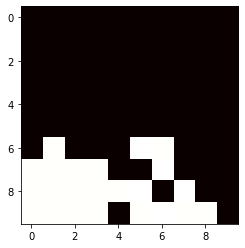

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,.,c,c,a,b,.,3,a,a
H,.,.,.,.,a,c,.,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 143 Puntos:646
Almacen: [.] Actual: [a]


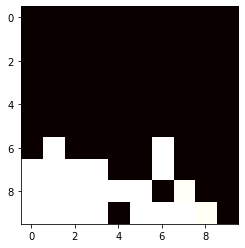

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,.,c,a,2,c,3,a,c,2
F,b,.,2,a,c,b,c,a,2,a
G,c,b,c,c,a,b,.,3,a,a
H,.,.,.,.,a,c,.,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 144 Puntos:649
Almacen: [.] Actual: [a]


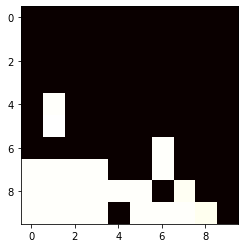

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,.,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,b,c,c,a,b,.,3,a,a
H,.,.,.,.,a,c,.,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 145 Puntos:650
Almacen: [.] Actual: [a]


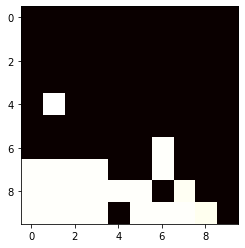

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,b,c,c,a,b,.,3,a,a
H,.,.,.,.,a,c,.,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 146 Puntos:651
Almacen: [.] Actual: [a]


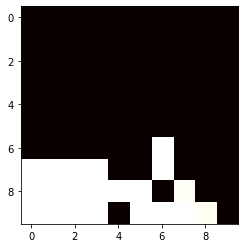

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,b,c,c,a,b,a,3,a,a
H,.,.,.,.,a,c,.,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 147 Puntos:652
Almacen: [.] Actual: [a]


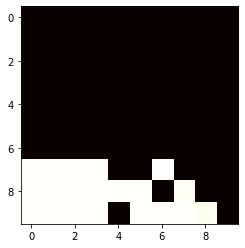

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,b,c,c,a,b,a,3,a,a
H,.,.,.,.,a,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 148 Puntos:653
Almacen: [.] Actual: [a]


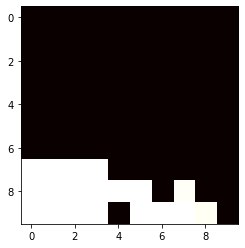

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,b,c,c,a,b,a,3,a,a
H,a,.,.,.,a,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 149 Puntos:654
Almacen: [.] Actual: [a]


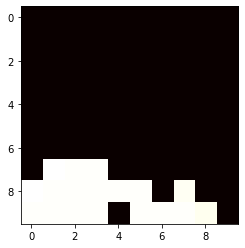

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,b,c,c,a,b,a,3,a,a
H,a,a,.,.,a,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 150 Puntos:655
Almacen: [.] Actual: [a]


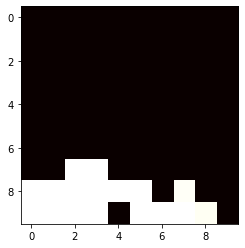

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,b,c,c,a,b,a,3,a,a
H,.,.,b,.,a,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 151 Puntos:658
Almacen: [.] Actual: [a]


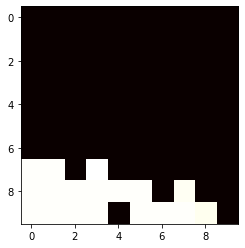

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,c,b,c,a,2,a
G,c,b,c,c,.,b,a,3,a,a
H,.,.,b,b,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 152 Puntos:661
Almacen: [.] Actual: [b]


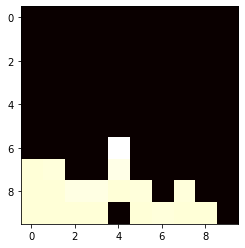

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,.,.,c,a,2,a
G,c,b,.,.,d,.,a,3,a,a
H,.,.,b,b,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 153 Puntos:701
Almacen: [.] Actual: [a]


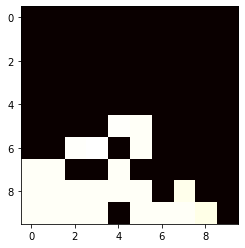

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,.,2,c,3,a,c,2
F,b,a,2,.,.,.,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 154 Puntos:714
Almacen: [.] Actual: [a]


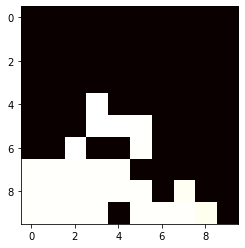

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,.,.,.,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 155 Puntos:715
Almacen: [.] Actual: [a]


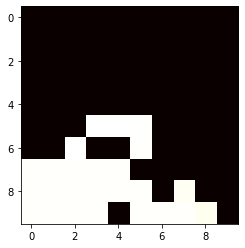

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,a,2,c,3,a,c,2
F,b,a,2,a,.,.,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 156 Puntos:716
Almacen: [.] Actual: [a]


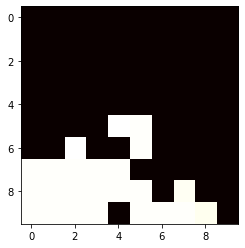

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,.,2,c,3,a,c,2
F,b,a,2,.,b,.,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 157 Puntos:719
Almacen: [.] Actual: [1]


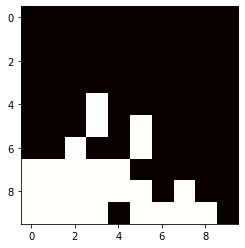

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,1,2,c,3,a,c,2
F,b,a,2,.,b,.,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 158 Puntos:694
Almacen: [.] Actual: [a]


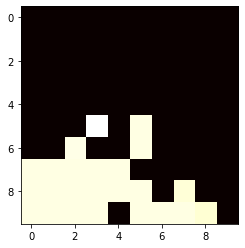

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 159 Puntos:715
Almacen: [.] Actual: [a]


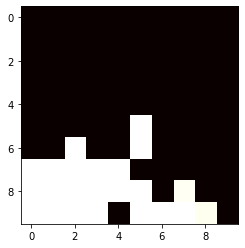

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,2
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,a,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 160 Puntos:716
Almacen: [.] Actual: [w]


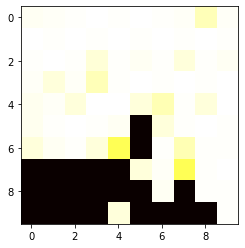

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,.
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,a,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 161 Puntos:721
Almacen: [.] Actual: [a]


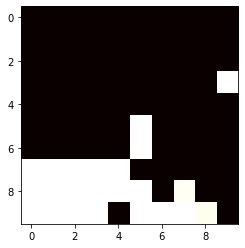

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,.,b
D,a,c,a,3,a,2,a,2,.,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,a,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 162 Puntos:724
Almacen: [.] Actual: [a]


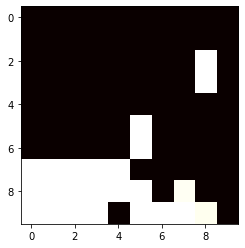

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,.,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,a,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 163 Puntos:725
Almacen: [.] Actual: [a]


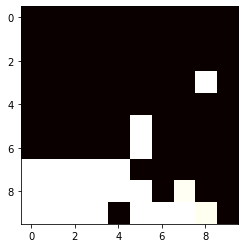

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,a,c,d,.,a,3,a,a
H,.,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 164 Puntos:726
Almacen: [.] Actual: [a]


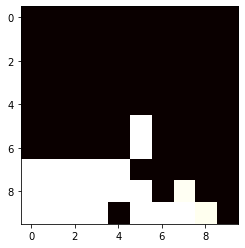

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,a,c,d,.,a,3,a,a
H,.,.,a,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 165 Puntos:727
Almacen: [.] Actual: [a]


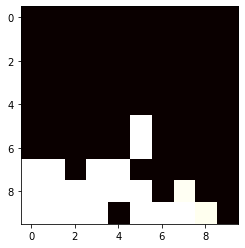

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,.,b,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 166 Puntos:730
Almacen: [.] Actual: [w]


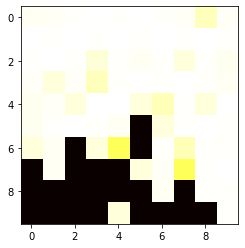

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,.,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,.,b,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 167 Puntos:735
Almacen: [.] Actual: [1]


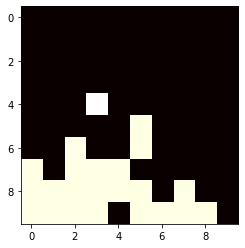

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,.,b,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 168 Puntos:730
Almacen: [.] Actual: [a]


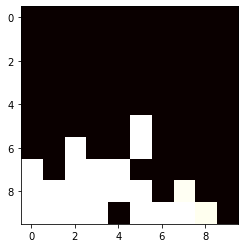

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,b,a,c,d,.,a,3,a,a
H,.,b,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 169 Puntos:731
Almacen: [.] Actual: [b]


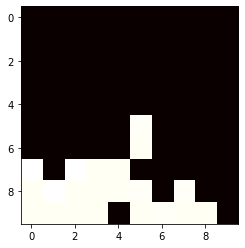

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,.,a,c,d,.,a,3,a,a
H,c,.,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 170 Puntos:746
Almacen: [.] Actual: [a]


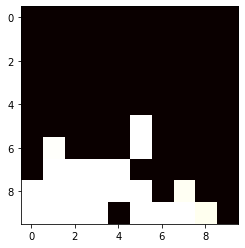

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,.,c,a,2,a
G,c,.,a,c,d,.,a,3,a,a
H,c,.,a,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 171 Puntos:747
Almacen: [.] Actual: [a]


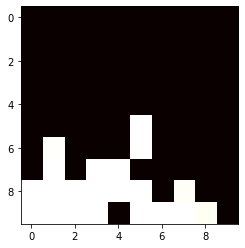

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,.,a,c,d,.,a,3,a,a
H,c,.,a,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 172 Puntos:748
Almacen: [.] Actual: [a]


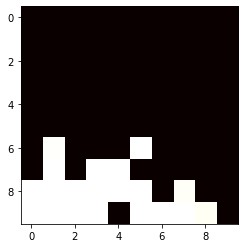

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,.,.,c,d,.,a,3,a,a
H,c,b,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 173 Puntos:751
Almacen: [.] Actual: [a]


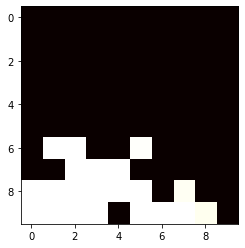

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,.,c,2,2,c,3,a,c,2
F,b,.,2,a,b,a,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,c,b,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 174 Puntos:754
Almacen: [.] Actual: [a]


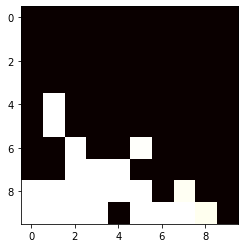

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,.,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,c,b,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 175 Puntos:755
Almacen: [.] Actual: [a]


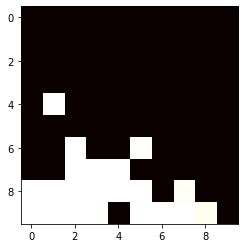

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,.,c,d,.,a,3,a,a
H,c,b,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 176 Puntos:756
Almacen: [.] Actual: [1]


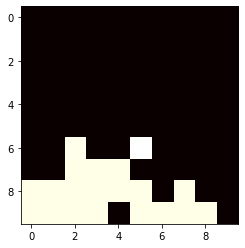

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,.,c,d,2,a,3,a,a
H,c,b,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 177 Puntos:751
Almacen: [.] Actual: [a]


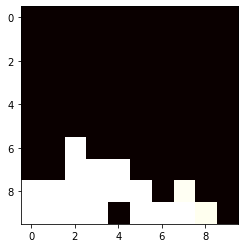

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,a,c,d,2,a,3,a,a
H,c,b,.,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 178 Puntos:752
Almacen: [.] Actual: [a]


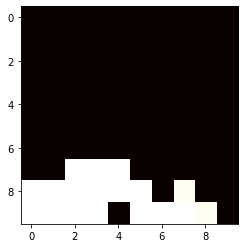

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,a,c,d,2,a,3,a,a
H,c,b,a,.,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 179 Puntos:753
Almacen: [.] Actual: [a]


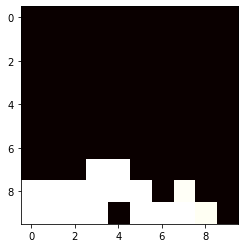

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,.,c,d,2,a,3,a,a
H,c,b,.,b,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 180 Puntos:756
Almacen: [.] Actual: [1]


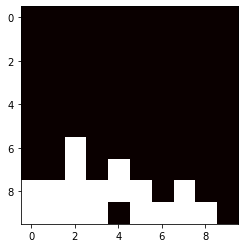

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,1,c,d,2,a,3,a,a
H,c,b,.,b,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 181 Puntos:731
Almacen: [.] Actual: [a]


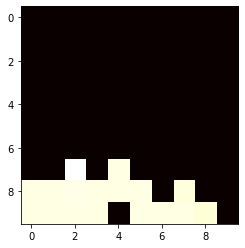

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,a,b,.,c,a,d,a,2
I,.,.,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 182 Puntos:752
Almacen: [.] Actual: [a]


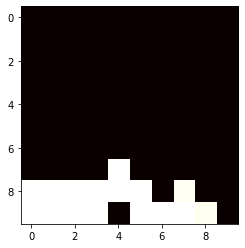

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,a,b,.,c,a,d,a,2
I,.,.,a,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 183 Puntos:753
Almacen: [.] Actual: [a]


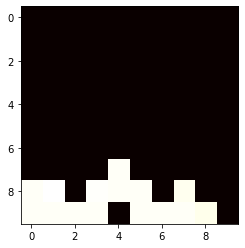

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,.,2,c,d,2,a,3,a,a
H,c,.,.,b,.,c,a,d,a,2
I,.,c,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 184 Puntos:766
Almacen: [.] Actual: [b]


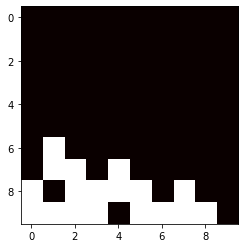

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,.,.,b,.,c,a,d,a,2
I,.,c,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 185 Puntos:771
Almacen: [.] Actual: [a]


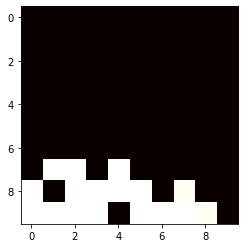

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,.,a,b,.,c,a,d,a,2
I,.,c,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 186 Puntos:772
Almacen: [.] Actual: [a]


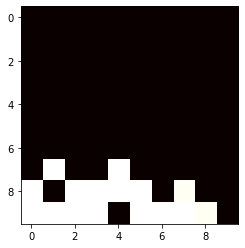

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,a,a,b,.,c,a,d,a,2
I,.,c,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 187 Puntos:773
Almacen: [.] Actual: [1]


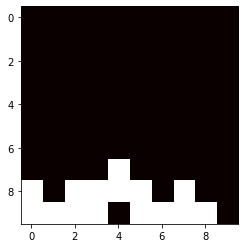

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,a,a,b,1,c,a,d,a,2
I,.,c,.,.,.,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 188 Puntos:748
Almacen: [.] Actual: [1]


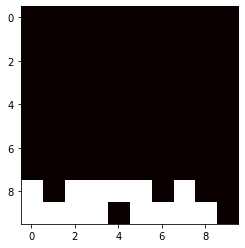

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,a,a,b,.,c,a,d,a,2
I,.,c,.,1,1,.,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 189 Puntos:723
Almacen: [.] Actual: [a]


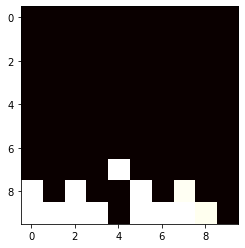

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,a,a,b,a,c,a,d,a,2
I,.,c,.,.,1,1,b,.,a,a
J,.,.,.,.,c,.,.,.,.,a



Turno: 190 Puntos:724
Almacen: [.] Actual: [b]


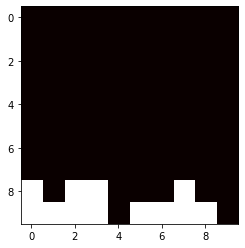

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,a,a,b,a,c,a,d,a,2
I,.,c,.,b,.,1,b,.,a,a
J,.,.,.,.,c,1,.,.,.,a



Turno: 191 Puntos:729
Almacen: [.] Actual: [a]


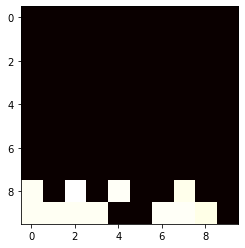

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,.,.,.,a,c,a,d,a,2
I,.,c,c,.,.,.,b,.,a,a
J,.,.,.,.,c,1,1,.,.,a



Turno: 192 Puntos:742
Almacen: [.] Actual: [b]


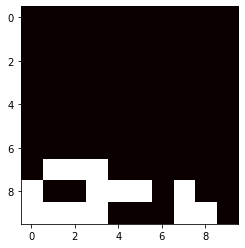

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,.,.,a,c,a,d,a,2
I,.,c,c,.,.,1,b,.,a,a
J,.,.,.,.,c,.,.,1,.,a



Turno: 193 Puntos:747
Almacen: [.] Actual: [b]


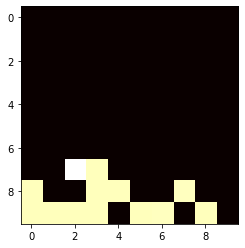

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,.,2,c,d,2,a,3,a,a
H,c,.,d,.,a,c,a,d,a,2
I,.,.,.,.,.,.,b,1,a,a
J,.,.,.,.,c,1,.,.,.,a



Turno: 194 Puntos:812
Almacen: [.] Actual: [a]


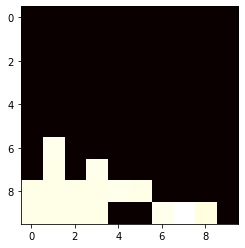

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,a,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,.,2,c,d,2,a,3,a,a
H,c,.,d,.,a,c,a,d,a,2
I,.,.,.,.,.,1,b,2,a,a
J,.,.,.,.,c,.,.,a,.,a



Turno: 195 Puntos:833
Almacen: [.] Actual: [a]


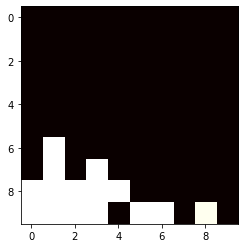

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,.,c,2,2,c,3,a,c,2
F,b,.,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,.,d,.,a,c,a,d,a,2
I,.,.,.,.,.,.,b,2,a,a
J,.,.,.,.,c,1,.,a,.,a



Turno: 196 Puntos:836
Almacen: [.] Actual: [a]


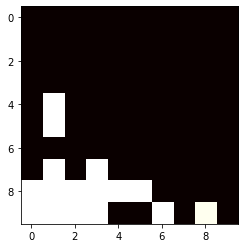

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,.,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,.,d,.,a,c,a,d,a,2
I,.,.,.,.,.,1,b,2,a,a
J,.,.,.,.,c,.,.,a,.,a



Turno: 197 Puntos:837
Almacen: [.] Actual: [1]


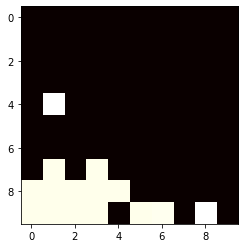

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,.,d,.,a,c,a,d,a,2
I,.,.,.,.,.,.,b,2,a,a
J,.,.,.,.,c,1,.,a,.,a



Turno: 198 Puntos:832
Almacen: [.] Actual: [a]


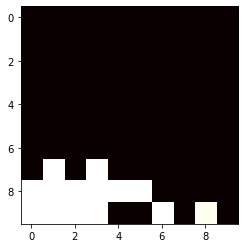

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,.,d,a,a,c,a,d,a,2
I,.,.,.,.,.,1,b,2,a,a
J,.,.,.,.,c,.,.,a,.,a



Turno: 199 Puntos:833
Almacen: [.] Actual: [a]


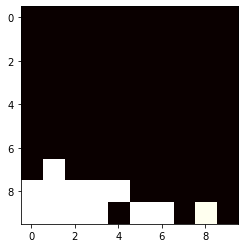

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,.,d,a,a,c,a,d,a,2
I,.,.,.,.,.,x,b,2,a,a
J,.,.,.,.,c,1,a,a,.,a



Turno: 200 Puntos:784
Almacen: [.] Actual: [b]


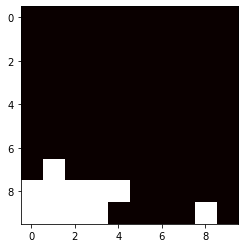

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,.,.,.,.,x,b,2,a,a
J,.,.,.,.,c,2,a,a,.,a



Turno: 201 Puntos:809
Almacen: [.] Actual: [1]


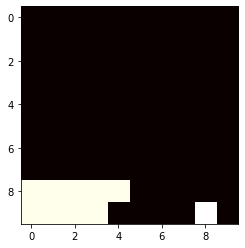

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,.,.,.,.,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 202 Puntos:804
Almacen: [.] Actual: [a]


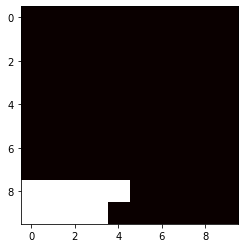

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,a,.,.,.,.,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 203 Puntos:805
Almacen: [.] Actual: [a]


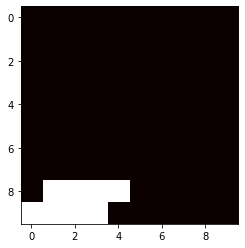

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,a,a,.,.,.,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 204 Puntos:806
Almacen: [.] Actual: [a]


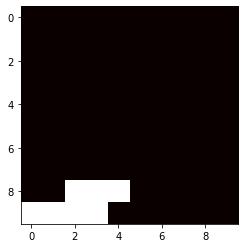

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,.,b,.,.,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 205 Puntos:809
Almacen: [.] Actual: [a]


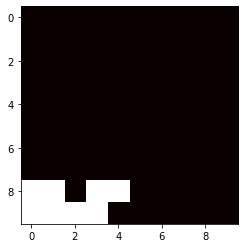

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,.,.,c,a,d,a,2
I,.,.,b,b,.,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 206 Puntos:812
Almacen: [.] Actual: [a]


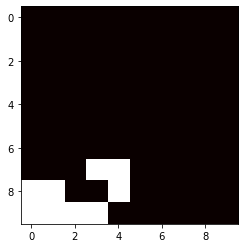

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,.,c,a,d,a,2
I,.,.,b,b,.,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 207 Puntos:813
Almacen: [.] Actual: [a]


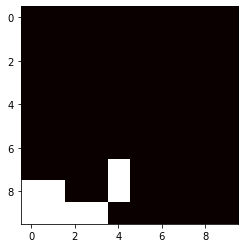

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,.,b,b,.,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 208 Puntos:814
Almacen: [.] Actual: [b]


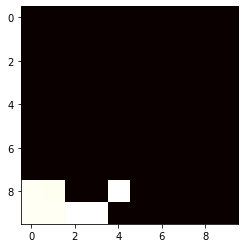

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,.,.,.,c,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 209 Puntos:829
Almacen: [.] Actual: [a]


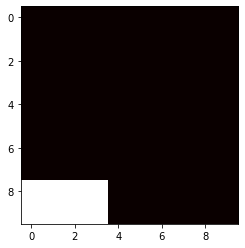

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,a,.,.,.,c,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 210 Puntos:830
Almacen: [.] Actual: [1]


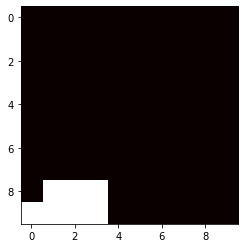

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,a,1,.,.,c,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 211 Puntos:805
Almacen: [.] Actual: [1]


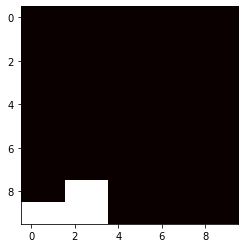

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,a,.,1,1,c,x,b,2,a,a
J,.,.,.,.,c,2,a,a,2,a



Turno: 212 Puntos:780
Almacen: [.] Actual: [a]


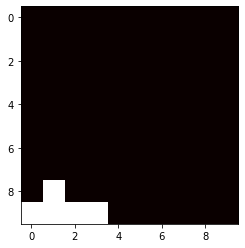

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,a,a,.,.,c,x,b,2,a,a
J,.,.,1,1,c,2,a,a,2,a



Turno: 213 Puntos:781
Almacen: [.] Actual: [a]


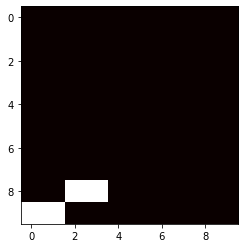

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,.,b,1,c,x,b,2,a,a
J,.,1,.,.,c,2,a,a,2,a



Turno: 214 Puntos:784
Almacen: [.] Actual: [a]


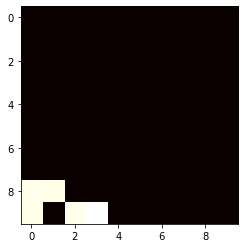

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,1,b,2,c,x,b,2,a,a
J,.,.,.,a,c,2,a,a,2,a



Turno: 215 Puntos:805
Almacen: [.] Actual: [a]


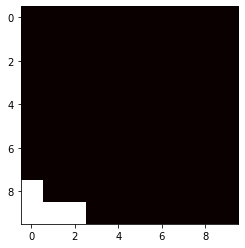

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,.,b,2,c,x,b,2,a,a
J,a,1,.,a,c,2,a,a,2,a



Turno: 216 Puntos:806
Almacen: [.] Actual: [1]


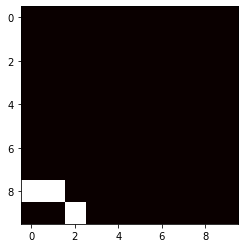

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,1,1,b,2,c,x,b,2,a,a
J,a,.,.,a,c,2,a,a,2,a



Turno: 217 Puntos:781
Almacen: [.] Actual: [1]


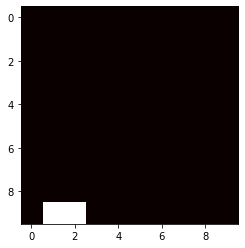

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,1,1,b,2,c,x,b,2,a,a
J,a,1,.,a,c,2,a,a,2,a



Turno: 218 Puntos:756
Almacen: [.] Actual: [a]


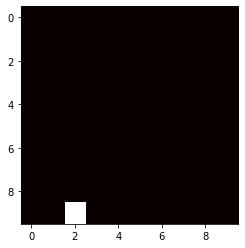

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,3,b,2,c,x,b,2,a,a
J,a,.,a,a,c,2,a,a,2,a



Turno: 219 Puntos:882
Almacen: [.] Actual: [a]


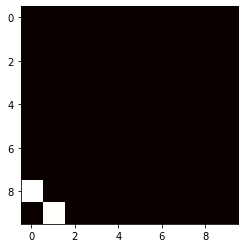

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,a,3,b,2,c,x,b,2,a,a
J,a,.,a,a,c,2,a,a,2,a



Turno: 220 Puntos:883
Almacen: [.] Actual: [a]


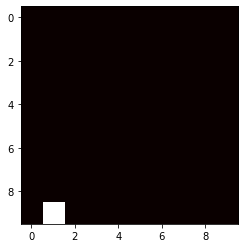

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,3,b,2,c,x,b,2,a,a
J,.,b,.,.,c,2,a,a,2,a



Turno: 221 Puntos:884
Almacen: [.] Actual: [a]


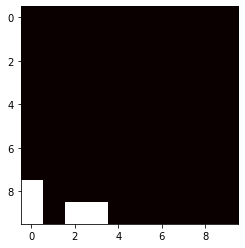

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,3,b,2,c,x,b,2,a,a
J,.,b,.,a,c,2,a,a,2,a



Turno: 222 Puntos:885
Almacen: [.] Actual: [a]


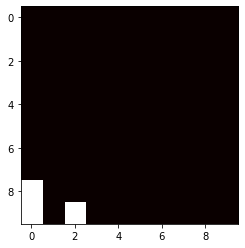

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,c,b,2,c,d,2,a,3,a,a
H,c,b,d,a,a,c,a,d,a,2
I,.,3,b,2,c,x,b,2,a,a
J,.,b,a,a,c,2,a,a,2,a



Turno: 223 Puntos:886
Almacen: [.] Actual: [c]


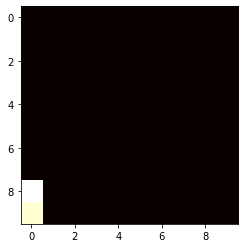

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,.,b,2,c,d,2,a,3,a,a
H,.,b,d,a,a,c,a,d,a,2
I,d,3,b,2,c,x,b,2,a,a
J,.,b,a,a,c,2,a,a,2,a



Turno: 224 Puntos:961
Almacen: [.] Actual: [a]


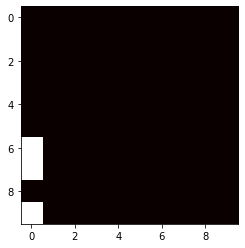

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,a,b,2,c,d,2,a,3,a,a
H,.,b,d,a,a,c,a,d,a,2
I,d,3,b,2,c,x,b,2,a,a
J,.,b,a,a,c,2,a,a,2,a



Turno: 225 Puntos:962
Almacen: [.] Actual: [a]


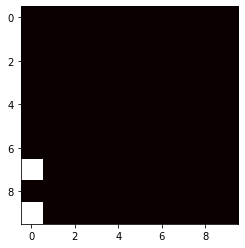

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,a,b,2,c,d,2,a,3,a,a
H,a,b,d,a,a,c,a,d,a,2
I,d,3,b,2,c,x,b,2,a,a
J,.,b,a,a,c,2,a,a,2,a



Turno: 226 Puntos:963
Almacen: [.] Actual: [a]


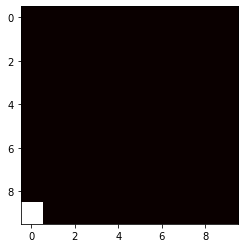

,0,1,2,3,4,5,6,7,8,9
A,b,a,a,2,a,2,a,a,3,a
B,2,a,2,a,2,a,2,a,2,a
C,a,2,a,c,a,b,a,c,a,b
D,a,c,a,3,a,2,a,2,a,b
E,b,2,c,2,2,c,3,a,c,2
F,b,a,2,a,b,a,c,a,2,a
G,a,b,2,c,d,2,a,3,a,a
H,a,b,d,a,a,c,a,d,a,2
I,d,3,b,2,c,x,b,2,a,a
J,a,b,a,a,c,2,a,a,2,a



Turno: 227 Puntos:964
Almacen: [.] Actual: [a]
Partida terminada, GG:👏


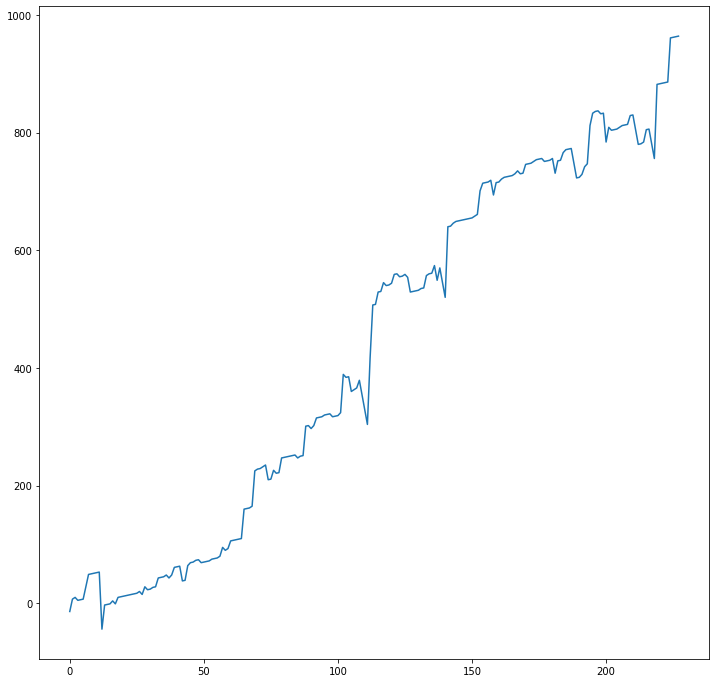

In [96]:
import random
import math
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}
 
class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements!=None:
          for i in startingElements: self.insert(i)
    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True      
    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]            
            else:
                return []        
            output[1 if node.end else 0] += node.char
        return output if node.end else []
    def toGraph(self):
      from pyvis.network import Network
      g = Network(directed =True)      
      g.show_buttons()

      nodeIndex = 1
      currentNode = 0
      q = [self.root]      
      g.add_node(currentNode, label="", color="red")
      tempLabels = {0:""}
      while q!=[]:
        n = q.pop(0)                     
        for i in n.children.values():
          tempLabels[nodeIndex] = tempLabels[currentNode]+i.char
          g.add_node(nodeIndex, label=tempLabels[currentNode]+i.char, color="#48e073" if i.end else "blue")
          g.add_edge(currentNode, nodeIndex)
          nodeIndex+=1
          q.append(i)
        currentNode+=1
      g.show('nx.html')

class MainGame:
  def __init__(self):
    #random.seed(368) #311
    self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
    self.checkAndLoadFiles()    
    self.turn = 0
    self.score = []
    self.storage = "."
    self.bigFoots = [[[i,j], 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]    
    self.updateActual()
    self.tr = Trie((''.join(chr(97+int(j)) for j in str(i))+str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
    self.tr.insert("exit")
    self.tr.insert("hint")
    self.tr.insert("*")
    self.tr.toGraph()

  def checkAndLoadFiles(self):
    try:
      with open("tablero.txt", "r") as f:
        self.matrix=[]        
        for i in f.readlines():
          self.matrix.append([])
          for j in i.replace("\n", ""):
            if not j in self.objects: raise
            self.matrix[-1].append(j)
    except:
      self.matrix = [random.sample(["."]*45+["a"]*18+["b"]*4+["c"]*3+["1"]*2, 10) for i in range(10)]
      print("Error al cargar el fichero tablero, usando tablero aleatorio...")      
    try:
      with open("secuencia.txt", "r") as f:
        self.seq=""
        for i in f.readline():
          if i not in self.objects and i != "w": raise
          self.seq += i
    except:
      self.seq = ""
      print("Error al cargar el fichero secuencia, usando secuencia aleatoria...")      

  def main(self):
    print("Que empiece el juego:\U0001F609")
    self.showGame()    
    while any("." in x for x in self.matrix):
      message = self.validarEntrada("hint")#self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
      while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

      if "".join(message[1])=="exit": break
      if "".join(message[1])=="*": self.storage=self.actual; self.updateActual(); self.showGame(); continue;
      coordinates = (lambda l: [int("".join([str(ord(i)%97) for i in l[0]])), int(l[1])])(message[1]) if "".join(message[1])!="hint" else self.getHint()
      if not ((self.matrix[coordinates[0]][coordinates[1]]==".") ^ (self.actual=="w")): print("Jugada errónea"); continue;

      self.updateMatrix(coordinates)
      self.updateActual()
      self.turn+=1
      self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
      
      self.showGame()
    print("Partida terminada, GG:\U0001F44F")
    fig = plt.figure(figsize=(12, 12))
    plt.plot(list(range(len(self.score))), self.score)
    plt.show()

  def getHint(self):
    prevObjs = sum(1 for a in self.matrix for b in a if b!=".")
    tempValues=[-math.inf, [0,0]]
    debugValues = [[0]*len(self.matrix[0]) for i in range(len(self.matrix))]
    for i in range(len(self.matrix)):
      for j in range(len(self.matrix[0])):
        if (self.matrix[i][j] == ".") ^ (self.actual=="w"): 
          newObj = copy.deepcopy(g)
          newObj.updateMatrix([i,j])
          newScore = sum(sum(self.objects[b][1] - (b == "." or 0) for b in a) for a in newObj.matrix) + (prevObjs - 3*newObj.minDistanceToElement((i,j), ["1", "2", newObj.matrix[i][j]]))
          if newScore>tempValues[0]: tempValues = [newScore, [i,j]]
          debugValues[i][j] = newScore
    plt.imshow(debugValues, cmap='hot', interpolation='nearest')
    plt.show()
    return tempValues[1]
  
  def minDistanceToElement(self, coordinates, elements):
    visited = set()
    q = [(coordinates, 0)]
    while q:
        n, distance = q.pop(0)
        if n in visited:
            continue
        visited.add(n)
        for i, j in ((n[0]-1, n[1]), (n[0]+1, n[1]), (n[0], n[1]-1), (n[0], n[1]+1)):
            if i < 0 or i >= len(self.matrix) or j < 0 or j >= len(self.matrix[0]):
                continue
            if self.matrix[i][j] in elements:
                return distance+1
            q.append(((i,j), distance+1))
    return 0   
  
  def updateActual(self):
    self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*6+["w"]*1) if self.seq=="" else self.seq[self.turn%len(self.seq)]
  
  def updateMatrix(self, coordinates):
    if self.actual=="w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
    self.matrix[coordinates[0]][coordinates[1]] = self.actual
    if self.actual=="1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

    self.checkAndColapse(coordinates)
    self.updateBigFoots()

  def checkAndColapse(self, coordinates):
    g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
    if g[1]=="2": coordinates = max(g[0], key=lambda x:[k for k in self.bigFoots if k[0]==x][0][1])
    while len(g[0])>2:
      for i in g[0]: 
        if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
        self.matrix[i[0]][i[1]] = "."
      self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
      g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
  
  def deleteBigFoot(self, coordinates):
    for i in range(len(self.bigFoots)):
      if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

  def updateBigFoots(self):
    for i in enumerate(self.bigFoots):
      n = i[1][:]
      if not n[2] and n[1]>0:
        for j in (lambda l:[k for k in l if k[0]>=0 and k[1]>=0])(([n[0][0]-1, n[0][1]], [n[0][0], n[0][1]+1], [n[0][0]+1, n[0][1]], [n[0][0], n[0][1]-1])):
          try:
            if self.matrix[j[0]][j[1]]==".": self.matrix[j[0]][j[1]]="1"; self.matrix[n[0][0]][n[0][1]]="x" if n[1]>10 else "."; self.bigFoots[i[0]][0]=j[:]; break;
          except: pass

      if n[0]==self.bigFoots[i[0]][0]: 
        g = self.getGroup(n[0], True)
        if not "." in (self.matrix[k[0]][k[1]] for k in g):
          for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0]==j][0]; self.bigFoots[bfIndex][2]=True;  
          self.checkAndColapse(n[0])

  def getGroup(self, coordinates, bigFootMode=False):    
    self.visitedMatrix = [[False]*len(self.matrix[0]) for i in range(len(self.matrix))]
    output = [coordinates]
    q = [coordinates]
    while q!=[]:
      n = q.pop(0)
      self.visitedMatrix[n[0]][n[1]] = True
      for i in (lambda l:[j for j in l if j[0]>=0 and j[1]>=0])([[n[0]-1, n[1]], [n[0], n[1]+1], [n[0]+1, n[1]], [n[0], n[1]-1]]):
        try:
          if (not self.visitedMatrix[i[0]][i[1]]) and (self.matrix[i[0]][i[1]]==self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]]==".")): q.append(i); output.append(i);
        except:
          pass
    return output

  def validarEntrada(self, s):
    s = self.tr.searchAndSplit(s)
    return (True if s else False, s)

  def showGame(self):
    df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65+int(j)) for j in str(i)) for i in range(len(self.matrix))])
    display(HTML(df.to_html()))
    self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
    print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")

if __name__=="__main__":
  g = MainGame()
  g.main()

**Bot Encoding**

In [ ]:
import copy
copyObj = copy.deepcopy(g)

In [ ]:
copyObj.__dict__

{'objects': {'.': ['.', 0],
  'a': ['b', 1],
  'b': ['c', 5],
  'c': ['d', 25],
  'd': ['e', 125],
  'e': ['e', 625],
  '1': ['1', -25],
  '2': ['3', -5],
  '3': ['4', 50],
  '4': ['4', 500],
  'x': ['x', -50]},
 'matrix': [['.', 'b', '1', '2', 'b', '1'],
  ['.', '.', '.', 'a', '3', '.'],
  ['.', '.', 'a', '.', 'c', 'c'],
  ['a', '.', '.', 'a', '.', 'c'],
  ['a', '.', 'a', 'a', '1', '.'],
  ['.', 'a', 'a', 'c', '.', 'b']],
 'seq': '',
 'turn': 9,
 'score': [67, 42, 43, 18, 20, -5, -30, 116, 116, 116, 116, 116, 119, 94],
 'storage': '.',
 'bigFoots': [[[4, 4], 9, False],
  [[0, 2], 9, False],
  [[0, 3], 7, True],
  [[0, 5], 1, False]],
 'actual': 'a',
 'tr': <__main__.Trie at 0x7f2aa84123d0>,
 'visitedMatrix': [[False, False, False, False, False, True],
  [False, False, False, False, False, True],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False]]}

Que empiece el juego:😉


,0,1,2,3,4,5
A,a,.,a,2,b,.
B,.,1,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 7 Puntos:116
Almacen: [.] Actual: [a]
Mover a casilla: a1


,0,1,2,3,4,5
A,.,b,.,2,b,.
B,.,.,1,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,1,c
E,a,.,a,a,.,.
F,.,a,a,c,.,b



Turno: 8 Puntos:119
Almacen: [.] Actual: [1]
Mover a casilla: a5


,0,1,2,3,4,5
A,.,b,1,2,b,1
B,.,.,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 9 Puntos:94
Almacen: [.] Actual: [a]
Mover a casilla: exit
Partida terminada, GG:👏


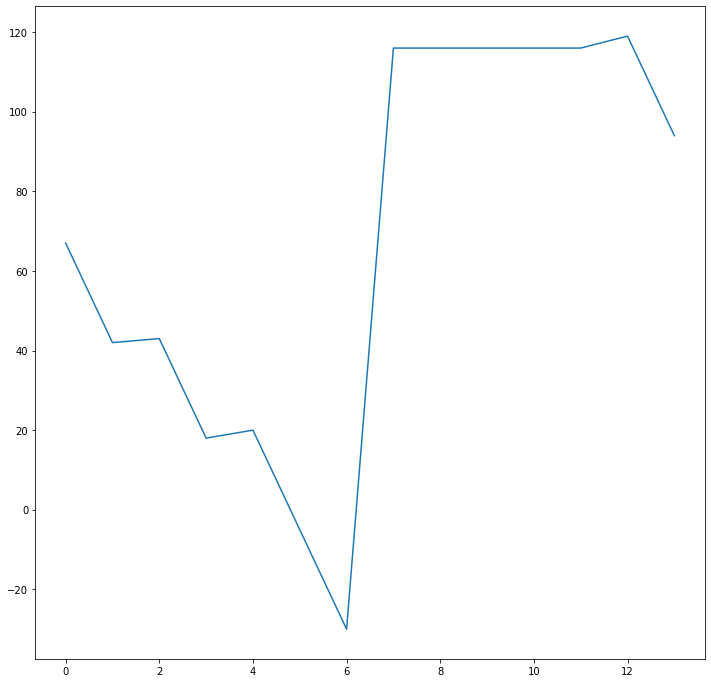

In [ ]:
copyObj.main()